# Upload Dataset

In [2]:
import os
import zipfile

# Rename file to a clean name
os.rename('/content/archive (4).zip', '/content/car_truck.zip')


In [3]:
# Extract the zip
with zipfile.ZipFile('/content/car_truck.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/car_truck')

In [4]:
import warnings, os
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Reproducibility; get the same result each time you run the code
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Set matplotlib default
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=18,
    titlepad=10
)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")  # to clean up output cells


# Load training and validation set
ds_train = image_dataset_from_directory(
    '/content/car_truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True
)

ds_valid = image_dataset_from_directory(
    '/content/car_truck/valid',   # folder containing training dataset
    labels='inferred',    # automatically assign labels
    label_mode='binary',   # his returns labels as 0 or 1
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)   # convert image pixel values from [0, 25] to [0.0, 1.0]
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

ds_train = (
    ds_train
    .map(convert_to_float)  # Applies the conversion to every image to label pair
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers

# Define pretrained base
pretrained_base = VGG16(
    input_shape =(128, 128, 3),  # match your image size
    include_top=False,   # Don't include the final classification layers
    weights='imagenet'  # Load pretrained ImageNet
)

# Freeze the base model
pretrained_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# The Head

In [6]:
# NOTE: pretrained base (like VGG16) outputs a feature map — a 2D representation
#  Head (the classifier) needs 1D input, so we first flatten or pool the feature map.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Train

In [7]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=1
)

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - binary_accuracy: 0.7239 - loss: 0.5484 - val_binary_accuracy: 0.8214 - val_loss: 0.4095
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - binary_accuracy: 0.8455 - loss: 0.3743 - val_binary_accuracy: 0.8521 - val_loss: 0.3601
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - binary_accuracy: 0.8733 - loss: 0.3244 - val_binary_accuracy: 0.8586 - val_loss: 0.3372
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - binary_accuracy: 0.8903 - loss: 0.2907 - val_binary_accuracy: 0.8640 - val_loss: 0.3234
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - binary_accuracy: 0.8999 - loss: 0.2639 - val_binary_accuracy: 0.8693 - val_loss: 0.3148
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - binary_accuracy: 0.9106 - loss: 0.2413 - val_binary_accuracy: 0.8681 - val_loss: 0.3094
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - binary_accuracy: 0.9213 - loss: 0.2213 - val_binary_accuracy: 0.8701 - val_loss: 0.3062

<Axes: >

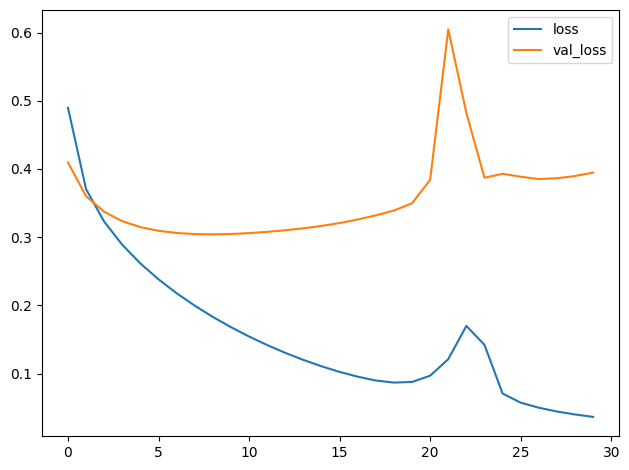

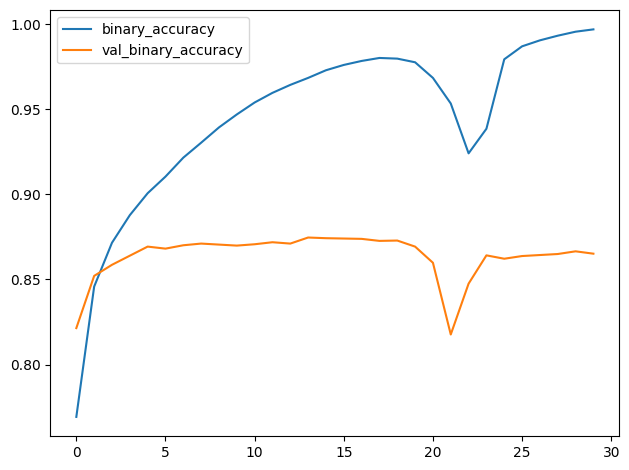

In [8]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()